# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


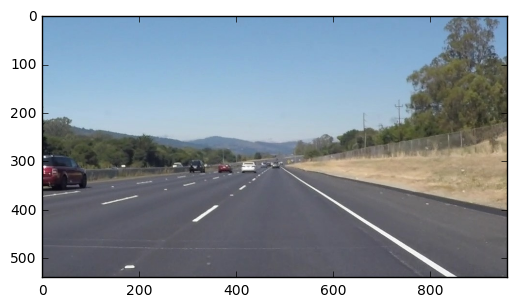

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # Define the use of global variables
    global last_right_gradient
    global last_left_gradient  
    global last_bottom_right
    global last_top_right
    global last_bottom_left
    global last_top_left
    
    # Define variables used for tweaking the lines
    alp = 0.2
    
    # Additional variables used for minor tweaks. Kept at 0 in current file
    # as the tweaks were not necessary
    left_gradient_offset = 0
    right_gradient_offset = 0
    right_line_offset = 0
    left_line_offset = 0
    
    # Local variables used for keeping track of both left and right line which include
    # 1. number of counts of left and right lines
    # 2. total gradient for left and right lines
    # 3. longest line in left and right lines
    left_count = 0
    left_gradient_total = 0
    left_longest = 0
    right_count = 0
    right_gradient_total = 0
    right_longest = 0
    
    # Run through all lines identified by hough transform
    if(lines is not None):
        for line in lines:
            for x1,y1,x2,y2 in line:

                # If x2 != x1 (not vertical lines) and gradient > 0.4
                # consider the line as a right line and add to right_gradient_total
                if (x2 != x1 and float(y2-y1)/(x2-x1) > 0.4):
                    # Uncomment below to see all lines drawn
                    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    right_gradient_total += float(y2-y1)/(x2-x1)                
                    right_count += 1

                    # Find the longest line on the right so that coordinates can be used for line extrapolation
                    if(math.sqrt((y2-y1)**2 + (x2-x1) ** 2) > right_longest):
                        right_longest = math.sqrt((y2-y1)**2 + (x2-x1) ** 2)
                        right_longest_line = line

                # If x2 != x1 (not vertical lines) and gradient < -0.4
                # consider the line as a left line and add to left_gradient_total            
                elif(x2 != x1 and float(y2-y1)/(x2-x1) < -0.4):
                    # Uncomment below to see all lines drawn                
                    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    left_gradient_total += float(y2-y1)/(x2-x1)
                    left_count += 1

                    # Find the longest line on the left so that coordinates can be used for line extrapolation
                    if(math.sqrt((y2-y1)**2 + (x2-x1) ** 2) > left_longest):
                        left_longest = math.sqrt((y2-y1)**2 + (x2-x1) ** 2)
                        left_longest_line = line
                        
    
    # If there are right lines in this image, draw the extrapolated right line
    if(right_count != 0):
        
        avg_right_gradient = right_gradient_total / right_count + right_gradient_offset
        
        # If first frame, assign new avg_right_gradient to last_right_gradient
        if(last_right_gradient == 0):
            last_right_gradient = avg_right_gradient
        else:
            avg_right_gradient = last_right_gradient*(1-alp)+avg_right_gradient*alp
            last_right_gradient = avg_right_gradient
        
        # Using the right_longest_line x1 value, extrapolate line using avg_right_gradient
        for x1,y1,x2,y2 in right_longest_line:  
            #Uncomment below to check which is the longest line chosen
            #cv2.line(img, (x1,y1), (x2,y2), [0,255,0], thickness)    
            bottom_right = (int((ysize - y2) / avg_right_gradient + x2 - right_line_offset),ysize)
            top_right = (int(((ysize * 6.0 / 10) - y2) / avg_right_gradient + x2 - right_line_offset),int(ysize * 6.0 / 10))
            
            # If first frame, assign new points to last known point
            if(last_bottom_right == (0,0)):
                last_bottom_right = bottom_right
                last_top_right = top_right
            else:
                # Using alp for smoothing of line transitions between frames
                bottom_right = (int(last_bottom_right[0]*(1-alp)+bottom_right[0]*alp),int(last_bottom_right[1]*(1-alp)+bottom_right[1]*alp))
                # Update last_bottom_right
                last_bottom_right = bottom_right
                
                top_right = (int(last_top_right[0]*(1-alp)+top_right[0]*alp),int(last_top_right[1]*(1-alp)+top_right[1]*alp))
                last_top_right = top_right
                
            cv2.line(img, top_right, bottom_right, color, thickness)

    # If there are left lines in this image, draw the extrapolated left line
    # repeating what was done for the right side
    if(left_count != 0):
        avg_left_gradient = left_gradient_total / left_count - left_gradient_offset
        
        if(last_left_gradient == 0):
            last_left_gradient = avg_left_gradient
        else:
            avg_left_gradient = last_left_gradient*(1-alp)+avg_left_gradient*alp
            last_left_gradient = avg_left_gradient
            
        
        for x1,y1,x2,y2 in left_longest_line:
            #Uncomment below to check which is the longest line chosen
            #cv2.line(img, (x1,y1), (x2,y2), [0,255,0], thickness)
            bottom_left = (math.ceil((ysize - y2) / avg_left_gradient + x2 + left_line_offset),ysize)
            top_left = (math.ceil(((ysize * 6.0 / 10) - y2) / avg_left_gradient + x2 + left_line_offset),int(ysize * 6.0 / 10))        
            
            
            if(last_bottom_left == (0,0)):
                last_bottom_left = bottom_left
                last_top_left = top_left
            else:
                bottom_left = (int(last_bottom_left[0]*(1-alp)+bottom_left[0]*alp),int(last_bottom_left[1]*(1-alp)+bottom_left[1]*alp))
                last_bottom_left = bottom_left
                top_left = (int(last_top_left[0]*(1-alp)+top_left[0]*alp),int(last_top_left[1]*(1-alp)+top_left[1]*alp))
                last_top_left = top_left
                
            cv2.line(img, top_left, bottom_left, color, thickness)                   


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
1
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
2
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
3
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
4
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
5
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
6


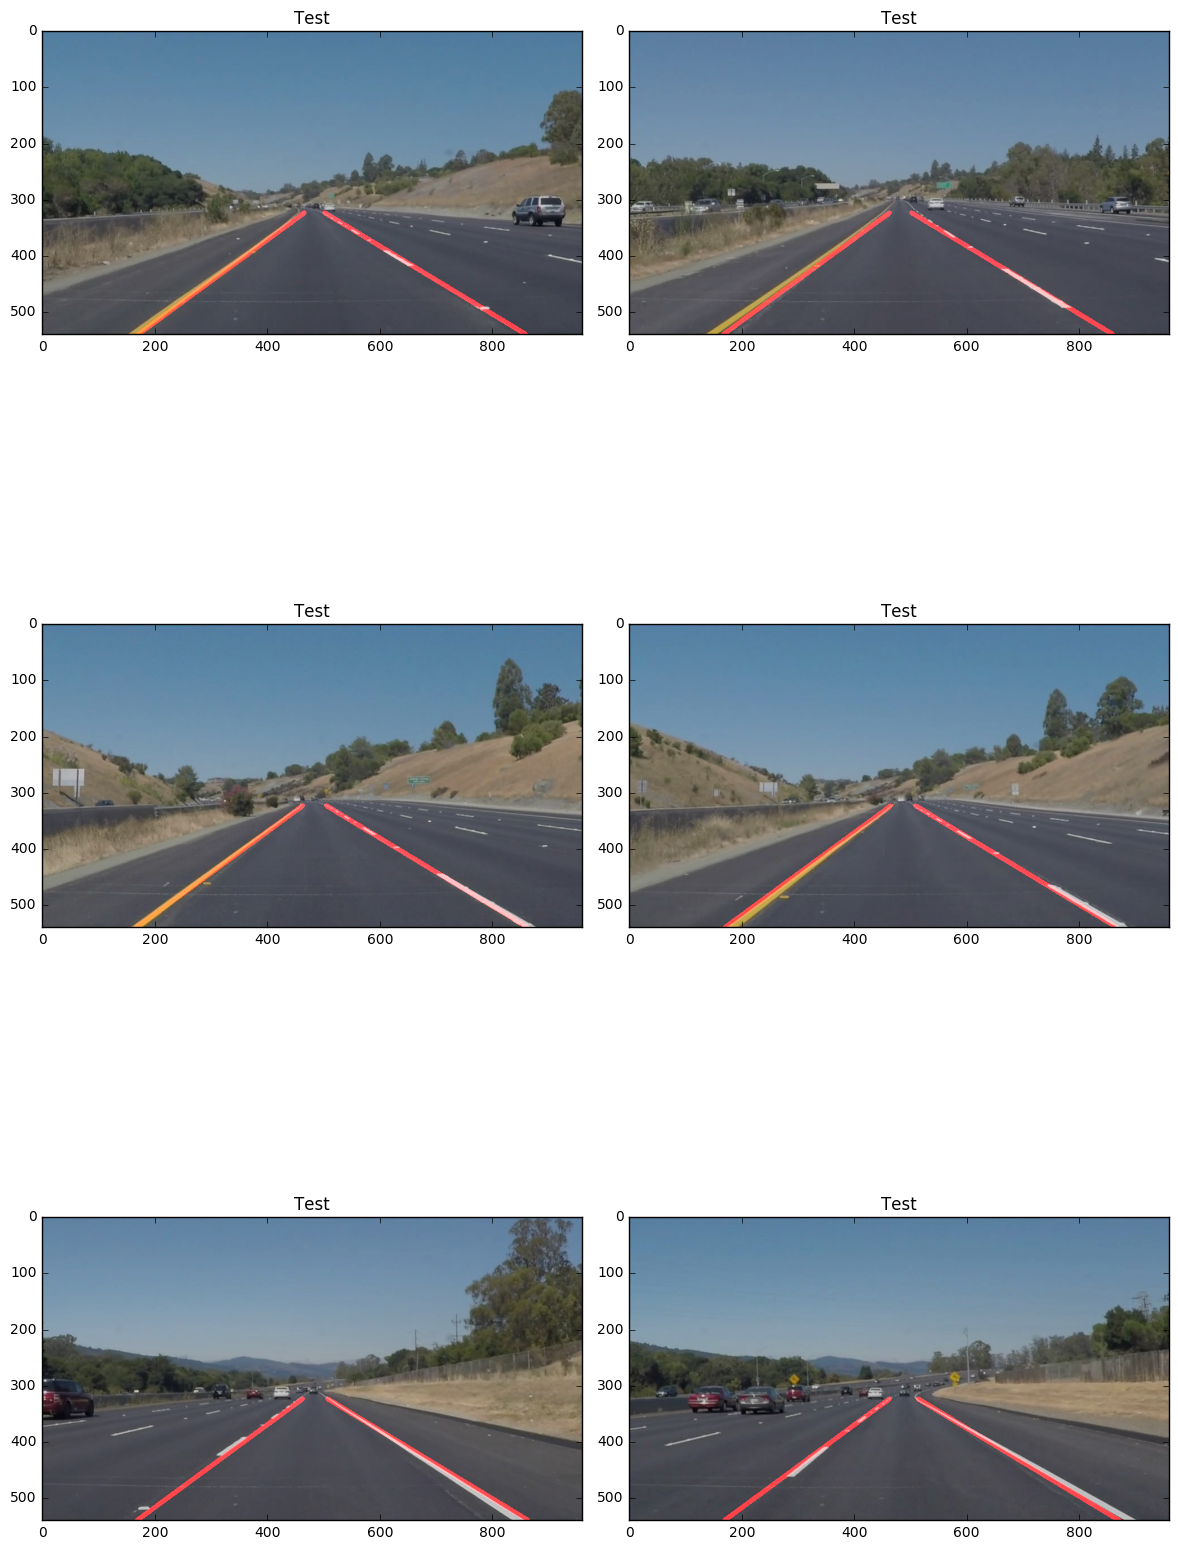

In [4]:
import os

"""
Global variables are defined to meet smoothening requirements for video but isn't necessary for images.

However, these variable are still initialize to meet requirements of functions in previous section
"""

# ysize and xsize of image
ysize = 0
xsize = 0
# Last known gradient for left and right line and initialise to 0
last_right_gradient = 0
last_left_gradient = 0
# Last known vertices for left and right line and initialise to (0,0)
last_bottom_right = (0,0)
last_top_right = (0,0)
last_bottom_left = (0,0)
last_top_left = (0,0)

def process(filename): 

    #reading in an image
    image = mpimg.imread('test_images/' + filename)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    
    # Extract size of image
    global ysize
    global xsize
    
    ysize = image.shape[0]
    xsize = image.shape[1]
     
    # Generate grayscale and hsv image for operation
    gray_image = grayscale(image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    """
    Line selection of yellow using image
    """    
    # define range of blue color in HSV
    lower_yellow = np.array([95,100,100])
    upper_yellow = np.array([105,255,255])    
    
    # Threshold the HSV image to get only yellow colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    
    """
    Line selection of white using gray scale image
    """    
    # Create grayscale image and mask all pixels < 200
    ret, white_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
    
    
    """
    Create final mask using white_mask and yellow_mask
    """      
    final_mask = cv2.bitwise_or(yellow_mask, white_mask)
    final_image = cv2.bitwise_and(gray_image,gray_image,mask = final_mask)

    
    """
    Define a vertices for area of interest and apply region of interest to final_mask   
    """      
    left_bottom = [xsize * 1 / 20, ysize]
    right_bottom = [xsize * 19 / 20, ysize]
    left_top = [xsize * 8 / 20, ysize * 13 / 20]
    right_top = [xsize * 12 / 20, ysize * 13 / 20]
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    selectedRegion = region_of_interest(final_image, vertices)
    
    
    """
    Perform gaussian blur to selected region followed by canny edge
    """
    # Apply gaussian blur
    blur_gray = gaussian_blur(selectedRegion, 5)
    
    # Define our parameters for Canny and apply   
    low_threshold = 50
    high_threshold = 150
    selectedRegion_canny = canny(blur_gray, low_threshold, high_threshold)
    
      
    """
    Apply hough transform to selectedRegion_canny
    """
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 60    # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(selectedRegion_canny, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create weighted image with hough_lines
    lines_edges = weighted_img(lines, image) 
    
    #Uncomment below to test individual images
    cv2.imwrite('test_images/Processed_' + filename , lines_edges)
    fig.add_subplot(3, 2, counter)
    plt.tight_layout()
    plt.imshow(lines_edges)
    plt.title('Test')
    

fig = plt.figure(figsize=(12, 20))
counter = 1
for filename in os.listdir("test_images/"):
    # Added due to negate .DS_Store file in folder
    if(filename != '.DS_Store'):
        process(filename)
        print(counter)
        counter += 1

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    # Extract size of image
    global ysize
    global xsize
    
    ysize = image.shape[0]
    xsize = image.shape[1]
     
    # Generate grayscale and hsv image for operation
    gray_image = grayscale(image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    """
    Line selection of yellow using image
    """    
    # define range of blue color in HSV
    lower_yellow = np.array([95,100,100])
    upper_yellow = np.array([105,255,255])    
    
    # Threshold the HSV image to get only yellow colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    
    """
    Line selection of white using gray scale image
    """    
    # Create grayscale image and mask all pixels < 200
    ret, white_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
    
    
    """
    Create final mask using white_mask and yellow_mask
    """      
    final_mask = cv2.bitwise_or(yellow_mask, white_mask)
    final_image = cv2.bitwise_and(gray_image,gray_image,mask = final_mask)

    
    """
    Define vertices for area of interest and apply region of interest to final_image   
    """      
    left_bottom = [xsize * 1 / 20, ysize]
    right_bottom = [xsize * 19 / 20, ysize]
    left_top = [xsize * 8 / 20, ysize * 13 / 20]
    right_top = [xsize * 12 / 20, ysize * 13 / 20]
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    selectedRegion = region_of_interest(final_image, vertices)
    
    
    """
    Perform gaussian blur to selected region followed by canny edge
    """
    # Apply gaussian blur
    blur_gray = gaussian_blur(selectedRegion, 5)
    
    # Define our parameters for Canny and apply   
    low_threshold = 50
    high_threshold = 150
    selectedRegion_canny = canny(blur_gray, low_threshold, high_threshold)
    
      
    """
    Apply hough transform to selectedRegion_canny
    """
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 60    # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(selectedRegion_canny, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create weighted image with hough_lines
    lines_edges = weighted_img(lines, image) 
    
    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [7]:
"""
Reinitialize global variables in this section for use
"""

# ysize and xsize of image
ysize = 0
xsize = 0
# Last known gradient for left and right line and initialise to 0
last_right_gradient = 0
last_left_gradient = 0
# Last known vertices for left and right line and initialise to (0,0)
last_bottom_right = (0,0)
last_top_right = (0,0)
last_bottom_left = (0,0)
last_top_left = (0,0)

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:08<00:00, 25.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 53.7 s, sys: 1.96 s, total: 55.7 s
Wall time: 9.02 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
"""
Reinitialize global variables in this section for use
"""

# ysize and xsize of image
ysize = 0
xsize = 0
# Last known gradient for left and right line and initialise to 0
last_right_gradient = 0
last_left_gradient = 0
# Last known vertices for left and right line and initialise to (0,0)
last_bottom_right = (0,0)
last_top_right = (0,0)
last_bottom_left = (0,0)
last_top_left = (0,0)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:28<00:00, 23.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 2s, sys: 6.68 s, total: 3min 8s
Wall time: 29.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

The current codes were written with the following flow

1. Convert image to hsv and create a yellow_mask to isolate all non yellow pixels
    1.1 Yellow regions were selected using HSV range from [95,100,100] to [105,255,255]
2. Convert image to grayscale and create a white_mask to isolate any pixels < 200
    2.1 White regions were selected for values > 200
3. Perform a bitwise_or on both white_mask and yellow_mask to create final_mask
4. Perform a bitwise_and on final_mask and grayscale image to create a final_image
5. Define vertices for area of interest and apply region of interest to final_image to create the selectedRegion
6. Perform gaussian blur on selectedRegion with kernal size of 5 to create blur_gray
7. Perform canny edge detection on blur_gray with the following settings to create selectedRegion_canny
    7.1 low_threshold = 50
    7.2 high_threshold = 150
8. Perform hough transform on selectedRegion_canny and extrapolate lines as follows
    8.1 Initialize variables to remember gradient and end points of left and right lines in previous frame
    8.2 Initialize alp variable to smoothen transition of line between 2 frames
    8.3 Initialize offset variable for minor tweaking of lines (if necessary)
    8.4 Initialize left and right gradient_total, gradient_count and longest line
    8.5 Run through all lines (if lines is not None) and separate lines into right lines (non vertical lines and 
    gradient > 0.4), and left lines (non vertical lines and gradient < -0.4). Store values for total gradient, 
    gradient line count and longest line for both left and right side
    8.6 In each frame if there are lines counted for right side, determine new gradient using (avg_right_gradient = 
    last_right_gradient*(1-alp)+avg_right_gradient * (alp)). Assign avg_right_gradient to last_right_gradient. 
    Using avg_right_gradient and x2,y2 points from the longest line on the right, extrapolate line to top and bottom 
    of selectedRegion
    8.7 Repeat 8.6 above for the left side
        
9. Use the output from hough transform to perform a final weighted_img with original image to create the final drawn image


Comment:
The current flow was satisfactory to handle all 3 videos including the challenge question. The short coming of the
current algorithm was that it will be unable to handle road condition where there are traffic and the vehicle comes
to a stop for successive frames. As the front vehicle may be blocking the road lines while the video frames are not
changing significantly, the algorithm will not be able to draw any useful lines to guide the vehicle when moving off
from stop.

Improvements to this problem will be to detect for vehicle stoppage and to continue to use the last drawn lines to 
guide the vehicle when moving off. As new road lines becomes available, update the guide lines with new values.

From the video at the end of the section, camera placement to avoid the car hood will most definitely help to ensure accuracy of line drawn. More can definitely be done to improve the algorithm. :)

Thank you Udacity for providing me the chance to participate in this course and learning so much through this project.



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
"""
Reinitialize global variables in this section for use
"""

# ysize and xsize of image
ysize = 0
xsize = 0
# Last known gradient for left and right line and initialise to 0
last_right_gradient = 0
last_left_gradient = 0
# Last known vertices for left and right line and initialise to (0,0)
last_bottom_right = (0,0)
last_top_right = (0,0)
last_bottom_left = (0,0)
last_top_left = (0,0)

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:17<00:00, 14.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 49s, sys: 3.95 s, total: 1min 53s
Wall time: 18.7 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [13]:
# Addtional testing video

"""
Reinitialize global variables in this section for use
"""

# ysize and xsize of image
ysize = 0
xsize = 0
# Last known gradient for left and right line and initialise to 0
last_right_gradient = 0
last_left_gradient = 0
# Last known vertices for left and right line and initialise to (0,0)
last_bottom_right = (0,0)
last_top_right = (0,0)
last_bottom_left = (0,0)
last_top_left = (0,0)

test_output = 'Processed_MOVI0718.mp4'
clip2 = VideoFileClip('MOVI0718.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video Processed_MOVI0718.mp4
[MoviePy] Writing video Processed_MOVI0718.mp4


100%|██████████| 3090/3090 [01:11<00:00, 43.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Processed_MOVI0718.mp4 

CPU times: user 7min 14s, sys: 15.4 s, total: 7min 30s
Wall time: 1min 11s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))